In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from prophet import Prophet
import threading


In [3]:
# Load the dataset 
sales_data = pd.read_csv("superSales 2.csv")

# Preview dataset
print("Dataset Loaded Successfully!")
print(sales_data.head())


Dataset Loaded Successfully!
    Invoice_ID Branch      City         Product_line  Unit_price  Quantity  \
0  101-17-6199      A  Plymouth   Food and beverages       45.79         7   
1  101-81-4070      C   Glasgow    Health and beauty       62.82         2   
2  102-06-2002      C   Glasgow    Sports and travel       25.25         5   
3  102-77-2261      C   Glasgow    Health and beauty       65.31         7   
4  105-10-6182      A  Plymouth  Fashion accessories       21.48         2   

   Tax_5  Total_price  Order_date Order_time Payment_method   costs  \
0  16.03       336.56  2023-03-13   19:44:00    Credit card  320.53   
1   6.28       131.92  2023-01-17   12:36:00        Ewallet  125.64   
2   6.31       132.56  2023-03-20   17:52:00           Cash  126.25   
3  22.86       480.03  2023-03-05   18:02:00    Credit card  457.17   
4   2.15        45.11  2023-02-27   12:22:00        Ewallet   42.96   

   gross_income  Rating  
0         16.03     7.0  
1          6.28     4.9

In [4]:
# Convert 'Order_date' to datetime and handle errors
sales_data['Order_date'] = pd.to_datetime(sales_data['Order_date'], errors='coerce')

# Drop rows with invalid dates
sales_data = sales_data.dropna(subset=['Order_date'])

# Extract 'YearMonth' for grouping
sales_data['YearMonth'] = sales_data['Order_date'].dt.to_period('M')

print("Data cleaned successfully!")
print(sales_data[['Order_date', 'YearMonth']].head())


Data cleaned successfully!
  Order_date YearMonth
0 2023-03-13   2023-03
1 2023-01-17   2023-01
2 2023-03-20   2023-03
3 2023-03-05   2023-03
4 2023-02-27   2023-02


In [5]:
# Ensure Total_price is numeric
sales_data['Total_price'] = pd.to_numeric(sales_data['Total_price'], errors='coerce')

# Group by YearMonth and Product_line
monthly_sales = sales_data.groupby(['YearMonth', 'Product_line']).agg({'Total_price': 'sum'}).reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()  # Convert to datetime


# Preview grouped data
print("Monthly sales data grouped successfully!")
print(monthly_sales.head())


Monthly sales data grouped successfully!
   YearMonth            Product_line  Total_price
0 2023-01-01  Electronic accessories     18831.27
1 2023-01-01     Fashion accessories     19345.10
2 2023-01-01      Food and beverages     19570.54
3 2023-01-01       Health and beauty     16383.18
4 2023-01-01      Home and lifestyle     20494.74


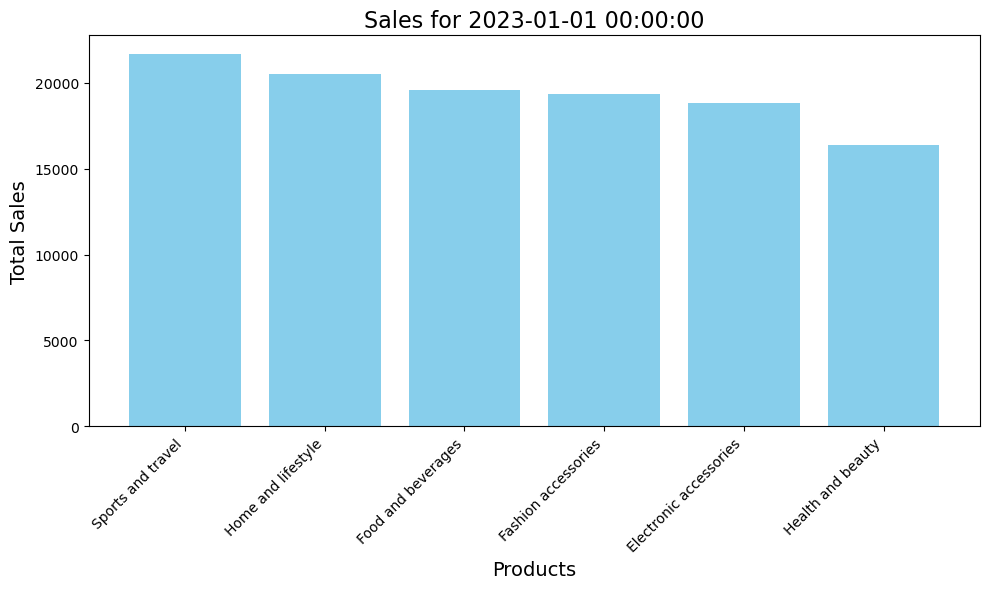

In [6]:
# Re-import required modules for safety
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the function to update the bar chart for each frame
def update_bar_chart(current_month_index):
    ax.clear()
    current_month = monthly_sales['YearMonth'].unique()[current_month_index]
    current_data = monthly_sales[monthly_sales['YearMonth'] == current_month]
    current_data = current_data.sort_values(by='Total_price', ascending=False)

    # Plot bar chart
    ax.bar(current_data['Product_line'], current_data['Total_price'], color='skyblue')
    ax.set_title(f"Sales for {current_month}", fontsize=16)
    ax.set_xlabel("Products", fontsize=14)
    ax.set_ylabel("Total Sales", fontsize=14)
    ax.set_xticks(range(len(current_data['Product_line'])))
    ax.set_xticklabels(current_data['Product_line'], rotation=45, ha='right')
    plt.tight_layout()

# Create the animation object
animation = FuncAnimation(fig, update_bar_chart, frames=len(monthly_sales['YearMonth'].unique()), interval=2000)

# Display the animation in Jupyter Notebook
from IPython.display import HTML
HTML(animation.to_jshtml())


/var/folders/rh/5l8ydfzx3csgt12sdn_jzjf40000gn/T/ipykernel_4275/3823289515.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data.rename(columns={'YearMonth': 'ds', 'Total_price': 'y'}, inplace=True)
11:12:18 - cmdstanpy - INFO - Chain [1] start processing
11:12:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/var/folders/rh/5l8ydfzx3csgt12sdn_jzjf40000gn/T/ipykernel_4275/3823289515.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Sales Predictions for the Next 6 Months:
          ds          yhat
0 2023-01-01  19502.914378
1 2023-02-01  18331.029383
2 2023-03-01  17272.552614
3 2023-03-31  16138.470362
4 2023-04-30  15004.388109
5 2023-05-31  13832.503115


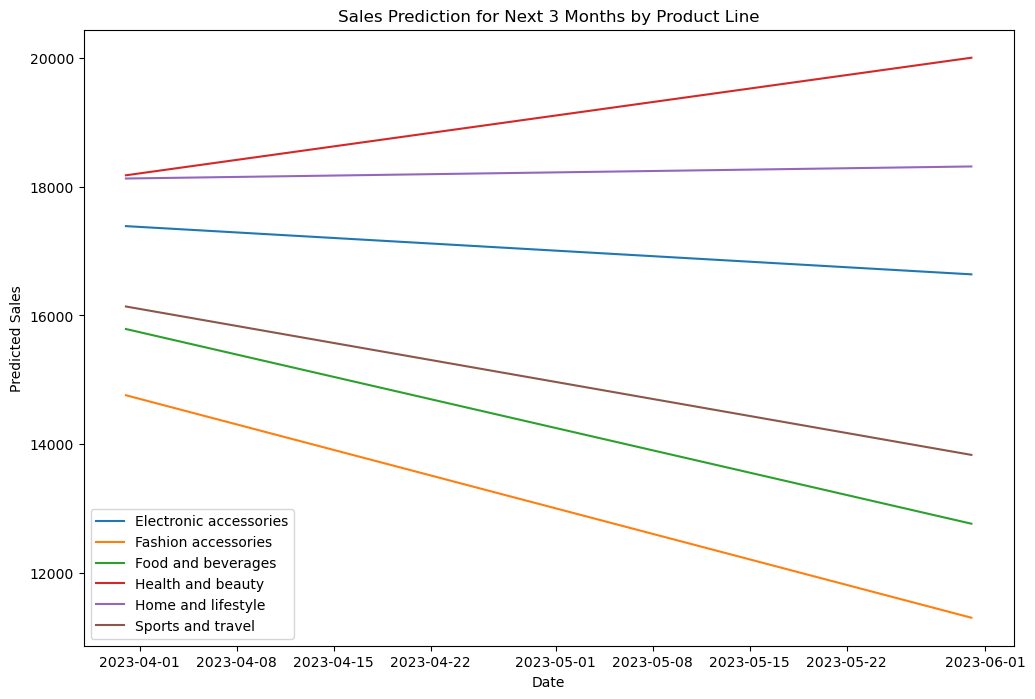

In [10]:
from prophet import Prophet

# Initialize dictionary to store forecasts
product_forecasts = {}

# Train a separate Prophet model for each Product_line
for product in monthly_sales['Product_line'].unique():
    product_data = monthly_sales[monthly_sales['Product_line'] == product]
    product_data.rename(columns={'YearMonth': 'ds', 'Total_price': 'y'}, inplace=True)
    
    # Train Prophet model
    model = Prophet()
    model.fit(product_data)
    
    # Predict future sales for 3 months
    future = model.make_future_dataframe(periods=3, freq='M')
    forecast = model.predict(future)
    
    # Save forecast
    product_forecasts[product] = forecast[['ds', 'yhat']].tail(3)



# Display forecast
print("Sales Predictions for the Next 6 Months:")
future_months = forecast[['ds', 'yhat']].tail(6)
print(future_months)

plt.figure(figsize=(12, 8))
for product, forecast in product_forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=product)

plt.title("Sales Prediction for Next 3 Months by Product Line")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.legend()
plt.show()



In [13]:
# Analyze total sales per product
total_sales = sales_data.groupby('Product_line').agg({'Total_price': 'sum'}).reset_index()
total_sales = total_sales.sort_values(by='Total_price', ascending=False)

# Display insights
print("Product with the Highest Sales:")
print(total_sales.iloc[0])

print("\nProducts Recommended for Discontinuation (Lowest Sales):")
print(total_sales.tail(5))


# Summarize product performance
top_products = sorted(product_forecasts.items(), key=lambda x: x[1]['yhat'].mean(), reverse=True)

print("\nTop 3 Predicted Products (Next 3 Months):")
for product, forecast in top_products[:3]:
    print(f"{product} - Predicted Average Sales: {forecast['yhat'].mean():.2f}")

print("\nProducts Recommended for Discontinuation (Lowest Sales):")
for product, forecast in top_products[-3:]:
    print(f"{product} - Predicted Average Sales: {forecast['yhat'].mean():.2f}")


Product with the Highest Sales:
Product_line    Food and beverages
Total_price               56144.87
Name: 2, dtype: object

Products Recommended for Discontinuation (Lowest Sales):
             Product_line  Total_price
5       Sports and travel     55122.91
0  Electronic accessories     54337.46
1     Fashion accessories     54305.91
4      Home and lifestyle     53861.91
3       Health and beauty     49193.74

Top 3 Predicted Products (Next 3 Months):
Health and beauty - Predicted Average Sales: 19086.09
Home and lifestyle - Predicted Average Sales: 18220.63
Electronic accessories - Predicted Average Sales: 17014.91

Products Recommended for Discontinuation (Lowest Sales):
Sports and travel - Predicted Average Sales: 14991.79
Food and beverages - Predicted Average Sales: 14284.05
Fashion accessories - Predicted Average Sales: 13040.06


In [14]:
def top_5_last_3_months():
    """Identify top 5 products sold in the last 3 months."""
    last_3_months = monthly_sales['YearMonth'].unique()[-3:]
    last_3_months_data = monthly_sales[monthly_sales['YearMonth'].isin(last_3_months)]
    top_5 = last_3_months_data.groupby('Product_line').agg({'Total_price': 'sum'}).reset_index()
    top_5 = top_5.sort_values(by='Total_price', ascending=False).head(5)
    print("\nTop 5 Products Sold in the Last 3 Months:")
    print(top_5)

# Execute the function
top_5_last_3_months()



Top 5 Products Sold in the Last 3 Months:
             Product_line  Total_price
2      Food and beverages     56144.87
5       Sports and travel     55122.91
0  Electronic accessories     54337.46
1     Fashion accessories     54305.91
4      Home and lifestyle     53861.91


In [17]:
# Handle missing values and incorrect data
sales_data = sales_data.dropna(subset=['Order_date', 'Total_price'])

# Convert 'Order_date' to datetime format
sales_data['Order_date'] = pd.to_datetime(sales_data['Order_date'], errors='coerce')

# Extract new features
sales_data['YearMonth'] = sales_data['Order_date'].dt.to_period('M')
sales_data['Day'] = sales_data['Order_date'].dt.day
sales_data['Weekday'] = sales_data['Order_date'].dt.weekday

# Aggregate data for monthly analysis
monthly_sales = sales_data.groupby(['YearMonth', 'Product_line']).agg({'Total_price': 'sum'}).reset_index()

# Prepare the dataset for modeling
features = sales_data[['Unit_price', 'Quantity', 'Tax_5', 'gross_income', 'Rating']]
target = sales_data['Total_price']


In [18]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)


Training Features Shape: (800, 5)
Testing Features Shape: (200, 5)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 1.6698758990000473
R² Score: 0.9999767226474452


In [20]:
def predict_sales(unit_price, quantity, tax, gross_income, rating,Product_line):
    """Predict sales for given inputs."""
    input_data = [[unit_price, quantity, tax, gross_income, rating ,Product_line]]
    predicted_sales = model.predict(input_data)
    return predicted_sales[0]


numeric_features = ['Unit_price', 'Quantity', 'Tax_5', 'gross_income', 'Rating']
categorical_features = ['Product_line']
print(f"Predicted Sales: {numeric_features,categorical_features}")


Predicted Sales: (['Unit_price', 'Quantity', 'Tax_5', 'gross_income', 'Rating'], ['Product_line'])


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Function for live data updates
def process_live_data(new_data):
    """Process and predict for incoming live data."""
    prediction = pipeline.predict(new_data)
    return prediction

# Simulate live data
new_sales_data = [[55, 12, 3.0, 18, 4.2]]  # Replace with actual incoming data
live_prediction = process_live_data(new_sales_data)
print("Live Prediction for Sales:", live_prediction)


Live Prediction for Sales: [199.2056]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


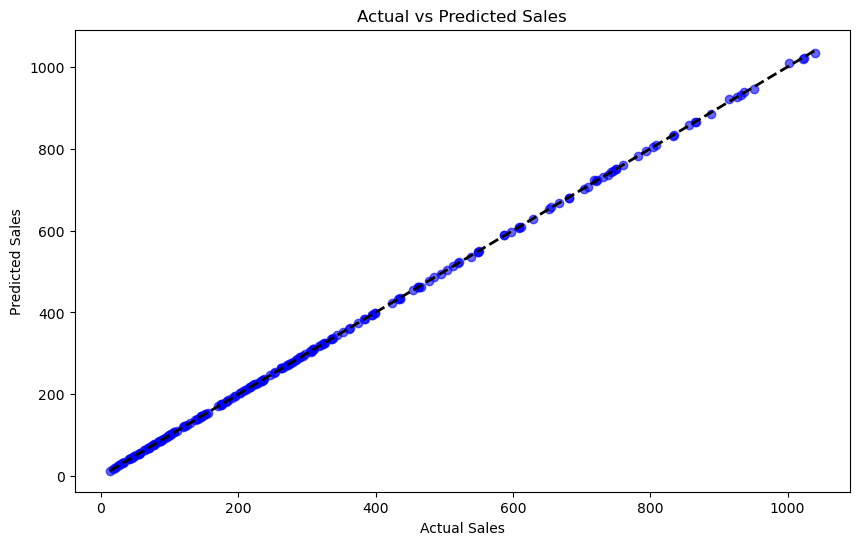

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


In [23]:
import joblib

# Save model
joblib.dump(pipeline, 'sales_prediction_pipeline.pkl')

# Load model
loaded_model = joblib.load('sales_prediction_pipeline.pkl')

# Predict using the loaded model
loaded_prediction = loaded_model.predict(new_sales_data)
print("Prediction from Loaded Model:", loaded_prediction)


Prediction from Loaded Model: [199.2056]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
